In [1]:
from PIL import Image
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.spatial.distance as distance
from sklearn import preprocessing

In [2]:
img_dir_list = ['PIE/1/*.jpg', 'PIE/4/*.jpg', 'PIE/5/*.jpg', \
               'PIE/19/*.jpg', 'PIE/21/*.jpg', 'PIE/23/*.jpg', \
               'PIE/25/*.jpg', 'PIE/29/*.jpg', 'PIE/33/*.jpg', \
               'PIE/39/*.jpg', 'PIE/40/*.jpg', 'PIE/44/*.jpg', \
               'PIE/45/*.jpg', 'PIE/46/*.jpg', 'PIE/48/*.jpg', \
               'PIE/52/*.jpg', 'PIE/57/*.jpg', 'PIE/58/*.jpg', \
               'PIE/59/*.jpg', 'PIE/67/*.jpg']
image_list = []
image_own = []
train_list = []
train_own = []
test_list = []
test_own = []
image_label = []
own_label = [20] * 10

for i in range (0, 20):
    for filename in glob.glob(img_dir_list[i]):
        im = Image.open(filename)
        arr = np.array(im).flatten()
        image_list.append(arr)
        image_label.append(i)
for filename in glob.glob('own_image/*.jpg'):
    im = Image.open(filename)
    arr = np.array(im).flatten()
    image_own.append(arr)
    
image_list = np.asarray(image_list)
image_own = np.asarray(image_own)
image_label = np.asarray(image_label)
own_label = np.asarray(own_label)

train_list, test_list, train_label, test_label = train_test_split(image_list, image_label, test_size = 0.3)
train_list = np.asarray(train_list)
test_list = np.asarray(test_list)
train_label = np.asarray(train_label)
test_label = np.asarray(test_label)

train_own, test_own, train_own_label, test_own_label = train_test_split(image_own, own_label, test_size = 0.3)
train_own = np.asarray(train_own)
test_own = np.asarray(test_own)
train_own_label = np.asarray(train_own_label)
test_label_own = np.asarray(test_own_label)

random_indices = np.arange(0, train_list.shape[0])
np.random.shuffle(random_indices)
train_sample = train_list[random_indices[:500]]
train_sample_label = train_label[random_indices[:500]]

train_sample = np.concatenate((train_sample, train_own))
train_sample_label = np.concatenate((train_sample_label, train_own_label))
test_list = np.concatenate((test_list, test_own))
test_label = np.concatenate((test_label, test_label_own))

In [3]:
sc = preprocessing.StandardScaler()
train_sample_prep = sc.fit_transform(train_sample)
test_list_prep = sc.transform(test_list)

In [4]:
train_image_mean = np.mean(train_sample_prep, axis = 0)
test_image_mean = np.mean(test_list_prep, axis = 0)

In [6]:
train_sample_matrix = []

for i in range(0, 21):
    temp_matrix = []
    for j in range(len(train_sample_prep)):
        if(train_sample_label[j] == i):
            temp_matrix.append(train_sample_prep[j])
    temp_matrix = np.asarray(temp_matrix)
    train_sample_matrix.append(temp_matrix)
train_sample_matrix = np.asarray(train_sample_matrix)

In [7]:
scatter_within_train = 0
scatter_between_train = 0

for i in range(21):
    train_mean_i = np.mean(train_sample_matrix[i], axis = 0)
    image_diff = train_sample_matrix[i] - train_mean_i
    covariance_i = (1 / train_sample_matrix[i].shape[0]) * np.matmul(image_diff.T, image_diff)
    
    p_train_i = train_sample_matrix[i].shape[0] / 507
    scatter_within_i_train = p_train_i * covariance_i
    scatter_within_train = scatter_within_train + scatter_within_i_train
    
    mean_temp = train_mean_i - train_image_mean
    mean_temp = mean_temp.reshape(1024, 1)
    scatter_between_i_train = np.matmul(mean_temp, mean_temp.T) * p_train_i
    scatter_between_train = scatter_between_train + scatter_between_i_train
print(scatter_within_train.shape)
print("----------------------")
print(scatter_between_train.shape)

(1024, 1024)
----------------------
(1024, 1024)


In [8]:
matmul_res = np.matmul(np.linalg.pinv(scatter_within_train), scatter_between_train)

eigenvalue_train, eigenvector_train = np.linalg.eig(np.mat(matmul_res))
idx = eigenvalue_train.argsort()[::-1]
eigenvalue_train = np.real(eigenvalue_train[idx])
eigenvector_train = np.real(eigenvector_train[:, idx])
eigenvalue_train = np.asarray(eigenvalue_train)
eigenvector_train = np.asarray(eigenvector_train)

In [9]:
def get_eigen_pair(eigenvalue, eigenvector):
    eigen_pairs = [(eigenvalue[i], eigenvector[:,i]) for i in range(len(eigenvalue))]
    eigen_pairs.sort(key=lambda k: k[0], reverse = True)
    return eigen_pairs

def reduce_dim(image_list, image_mean, eigenvalue, eigenvector, dim):
    eigenpair = get_eigen_pair(eigenvalue, eigenvector)
    w = np.hstack((eigenpair[0][1][:, np.newaxis], eigenpair[1][1][:, np.newaxis]))
    if (dim > 2):
        for i in range (2, dim):
            w = np.hstack((w, eigenpair[i][1][:, np.newaxis]))
    reduce_dim_result = (image_list - image_mean).dot(w)
    return reduce_dim_result.T

In [10]:
train_2_dim = reduce_dim(train_sample_prep, train_image_mean, eigenvalue_train, eigenvector_train, 2)
train_3_dim = reduce_dim(train_sample_prep, train_image_mean, eigenvalue_train, eigenvector_train, 3)
train_9_dim = reduce_dim(train_sample_prep, train_image_mean, eigenvalue_train, eigenvector_train, 9)

test_2_dim = reduce_dim(test_list_prep, train_image_mean, eigenvalue_train, eigenvector_train, 2)
test_3_dim = reduce_dim(test_list_prep, train_image_mean, eigenvalue_train, eigenvector_train, 3)
test_9_dim = reduce_dim(test_list_prep, train_image_mean, eigenvalue_train, eigenvector_train, 9)

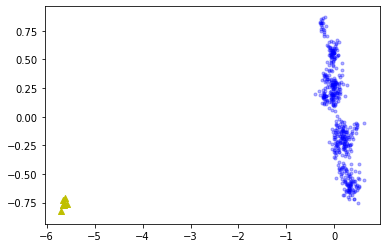

In [11]:
plt.figure()
plt.scatter(train_2_dim[0][:500], train_2_dim[1][:500], c = 'b', marker = '.', alpha = 0.3)
plt.scatter(train_2_dim[0][500:507], train_2_dim[1][500:507], c = 'y', marker = '^', alpha = 1)
plt.show()

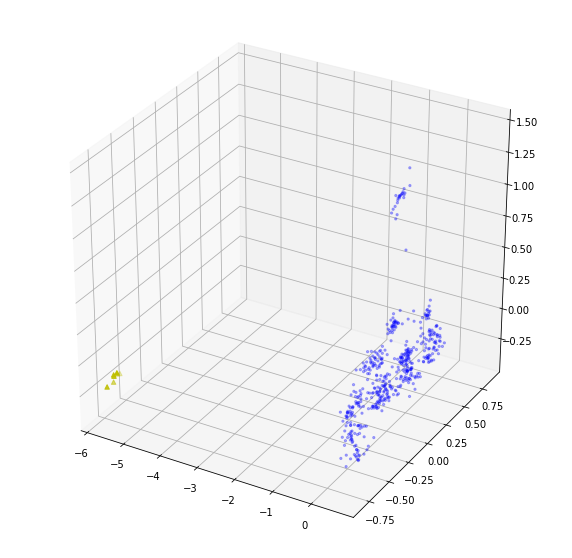

In [12]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(train_3_dim[0][:500], train_3_dim[1][:500], train_3_dim[2][:500], c = 'b', marker = '.', alpha = 0.3)
ax.scatter(train_3_dim[0][500:507], train_3_dim[1][500:507], train_3_dim[2][500:507], c = 'y', marker = '^')
plt.show()

In [13]:
def calc_Euclidean_dist(image_list, train_list):
    Euc_dist = np.array([[distance.euclidean(image_list[idx1], train_list[idx2]) for idx2 in np.arange(len(train_list))] for idx1 in np.arange(len(image_list))])
    return (Euc_dist)

def calc_knn_accuracy(distance, label_list, train_label_list):
    error_count = 0
    for idx, distance_1D in enumerate(distance):
        dist_idx = np.argsort(distance_1D)[:1]
        if (train_label_list[dist_idx] != label_list[idx]):
            error_count += 1
    error_rate = error_count / label_list.shape[0] * 100
    return (1 - error_rate)

In [14]:
test_2_euc_dist = calc_Euclidean_dist(test_2_dim.T, train_2_dim.T)
test_2_knn_accuracy = calc_knn_accuracy(test_2_euc_dist[:1020], test_label[:1020], train_sample_label)
test_2_own_knn_accuracy = calc_knn_accuracy(test_2_euc_dist[1020:1023], test_label[1020:1023], train_sample_label)


print(test_2_knn_accuracy, test_2_own_knn_accuracy)

-75.07843137254902 1.0


In [15]:
test_3_euc_dist = calc_Euclidean_dist(test_3_dim.T, train_3_dim.T)
test_3_knn_accuracy = calc_knn_accuracy(test_3_euc_dist[:1020], test_label[:1020], train_sample_label)
test_3_own_knn_accuracy = calc_knn_accuracy(test_3_euc_dist[1020:1023], test_label[1020:1023], train_sample_label)


print(test_3_knn_accuracy, test_3_own_knn_accuracy)

-62.23529411764706 1.0


In [16]:
test_9_euc_dist = calc_Euclidean_dist(test_9_dim.T, train_9_dim.T)
test_9_knn_accuracy = calc_knn_accuracy(test_9_euc_dist[:1020], test_label[:1020], train_sample_label)
test_9_own_knn_accuracy = calc_knn_accuracy (test_9_euc_dist[1020:1023], test_label[1020:1023], train_sample_label)

print(test_9_knn_accuracy, test_9_own_knn_accuracy)

-22.627450980392155 1.0
